# Import Libraries

In [1]:
import os
import cv2
import time
import random
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import deque
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

# Loading Models

In [2]:
main_path = 'model_path'

# Define a function to load TensorFlow Lite model
def load_tflite_model(file_path):
    interpreter = tf.lite.Interpreter(model_path=file_path)
    interpreter.allocate_tensors()
    return interpreter

# Define a function to load Keras model
def load_keras_model(file_path):
    return load_model(file_path)

# Iterate through files in main_path
for file in os.listdir(main_path):
    file_path = os.path.join(main_path, file)
    if file.endswith('.tflite'):
        # Load TensorFlow Lite model
        tflite_model = load_tflite_model(file_path)
        print("Loaded TensorFlow Lite model:", file_path)
    elif file.endswith('.h5'):
        # Load Keras model
        keras_model = load_keras_model(file_path)
        print("Loaded Keras model:", file_path)
        


Loaded Keras model: model_path\Model.h5
Loaded TensorFlow Lite model: model_path\Model.tflite


In [3]:
input_details = tflite_model.get_input_details()
output_details = tflite_model.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_input_1:0
shape: [  1 256 256   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 22]
type: <class 'numpy.float32'>


In [4]:
muscle_group = 'Hammer Curl'
workout = '22.mp4'
print(f'{muscle_group}/{workout}\n')

# Construct the input video file path
input_video_file_path = f'Videos/{muscle_group}/{workout}'

# import label from txt file
labels = []
with open(f'{main_path}/workout_label.txt', 'r') as f:
    for row in f:
        labels.append(row)
       
# Initialize video input
video_capture = cv2.VideoCapture(input_video_file_path)
# writer = None
H, W = None, None
Q = deque(maxlen=128)
n = 0
img_size = (input_details[0]['shape'][1], input_details[0]['shape'][2])

fps = video_capture.get(cv2.CAP_PROP_FPS)
frame_count = video_capture.get(cv2.CAP_PROP_FRAME_COUNT)
duration = frame_count/fps

print(f'Duration: {duration}')
print(f'FPS: {fps}')
print(f'Total frame: {frame_count}\n')

print('Prediction process')
start_time = time.time()

scan_count = 0
# Loop through each frame in the video
while True:
    # read a frame
    success, frame = video_capture.read()
    
    # if frame not read properly then break the loop
    if not success:
        break
    
    # count the frame
    n += 1
    
    if duration < 5.0:
        # predict every 10 frame (1, 11, 21, ... etc)
        step = 1
    elif duration < 10.0:
        # predict every 15 frame (1, 16, 31, ... etc)
        step = 5
    else:
        # predict every 30 frame (1, 31, 61, ... etc)
        step = 10
    
    if n % step != 1:
        continue
    
    # get frame dimensions
    if W is None or H is None:
        (H, W) = frame.shape[:2]
    
    # clone the frame for the output then preprocess the frame for the prediction
    output = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, img_size).astype("float32")
    
    tflite_model.set_tensor(input_details[0]['index'], np.expand_dims(frame, axis=0))

    tflite_model.invoke()

    predictions = tflite_model.get_tensor(output_details[0]['index'])[0]
    
    Q.append(predictions)
    
    results = np.array(Q).mean(axis=0)
    i = np.argmax(results)
    label = labels[i]
    
    text = f'{label}'
#     cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 10)
    
#     if writer is None:
#         fourcc = cv2.VideoWriter_fourcc(*"XVID")
#         writer = cv2.VideoWriter('output.avi', fourcc, 30, (W, H), True)
        
#     writer.write(output)
    
#     plt.imshow(output)
#     plt.axis('off')
    
    # print(f'{n}, {text}\t{results[i]}')
    scan_count += 1
    
    target_frame = int(fps*2)
    
    # break the loop if prediction > 90% and video already more than 2 seconds (fps*2)
    if results[i] >= 0.9 and n >= target_frame:
        break

end_time = time.time()

print(f'\nActual video: {workout}')
print(f'Prediction: {text}')
print(f'confidence: {results[i]}')
print(f'Prediction time: {end_time - start_time} sec')
# print(f'Scan speed: {(end_time - start_time)/scan_count} per frame\n')

# writer.release()
# video_capture.release()

result_df = pd.DataFrame({'exercise': labels,
                          'percentage': results
                         })

result_df['exercise'] = result_df['exercise'].str.strip()
result_df = result_df.sort_values('percentage', ascending=False)
result_df = result_df.reset_index(drop=True)

result_df

Hammer Curl/22.mp4

Duration: 18.551866666666665
FPS: 29.97002997002997
Total frame: 556.0

Prediction process

Actual video: 22.mp4
Prediction: barbell biceps curl

confidence: 0.6844003796577454
Prediction time: 9.196784496307373 sec


,exercise,percentage
0,barbell biceps curl,6.844004e-01
1,lateral raises,1.715238e-01
2,deadlift,5.985821e-02
3,hammer curl,4.287058e-02
4,chest fly machine,1.393471e-02
5,leg raises,1.099607e-02
6,tricep dips,5.353573e-03
7,lat pulldown,2.832976e-03
8,leg extension,2.437291e-03
9,russian twist,1.906230e-03


# Confussion Matrix

In [5]:

DATA_DIR = 'images'
img_size = (256, 256)  # Adjust the image size to match the model's input size


# Load the dataset
ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR,
                                                 labels='inferred',
                                                 label_mode='categorical',
                                                 image_size=img_size,
                                                 shuffle=True,
                                                 subset='validation',
                                                 validation_split=0.2,
                                                 seed=1
                                                 )

# Define labels for testing
labels = ds.class_names

# Extract true labels
y_labels = np.concatenate([labels for images, labels in ds], axis=0)
y_labels = np.argmax(y_labels, axis=1)

# Make predictions
y_preds = np.argmax(keras_model.predict(ds), axis=1)

# Get classification report
print(classification_report(y_labels, y_preds, target_names=labels))

Found 13886 files belonging to 22 classes.
Using 2777 files for validation.
87/87 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step
                     precision    recall  f1-score   support

barbell biceps curl       0.07      0.07      0.07       146
        bench press       0.02      0.02      0.02       133
  chest fly machine       0.04      0.04      0.04       105
           deadlift       0.01      0.01      0.01       100
decline bench press       0.01      0.01      0.01       102
        hammer curl       0.04      0.03      0.04       115
         hip thrust       0.04      0.04      0.04       102
incline bench press       0.04      0.04      0.04       136
       lat pulldown       0.04      0.04      0.04       137
     lateral raises       0.08      0.08      0.08       163
      leg extension       0.03      0.03      0.03       112
         leg raises       0.04      0.04      0.04       113
              plank       0.09      0.09      0.09       211
            pull up       0.0

In [6]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (20,12))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

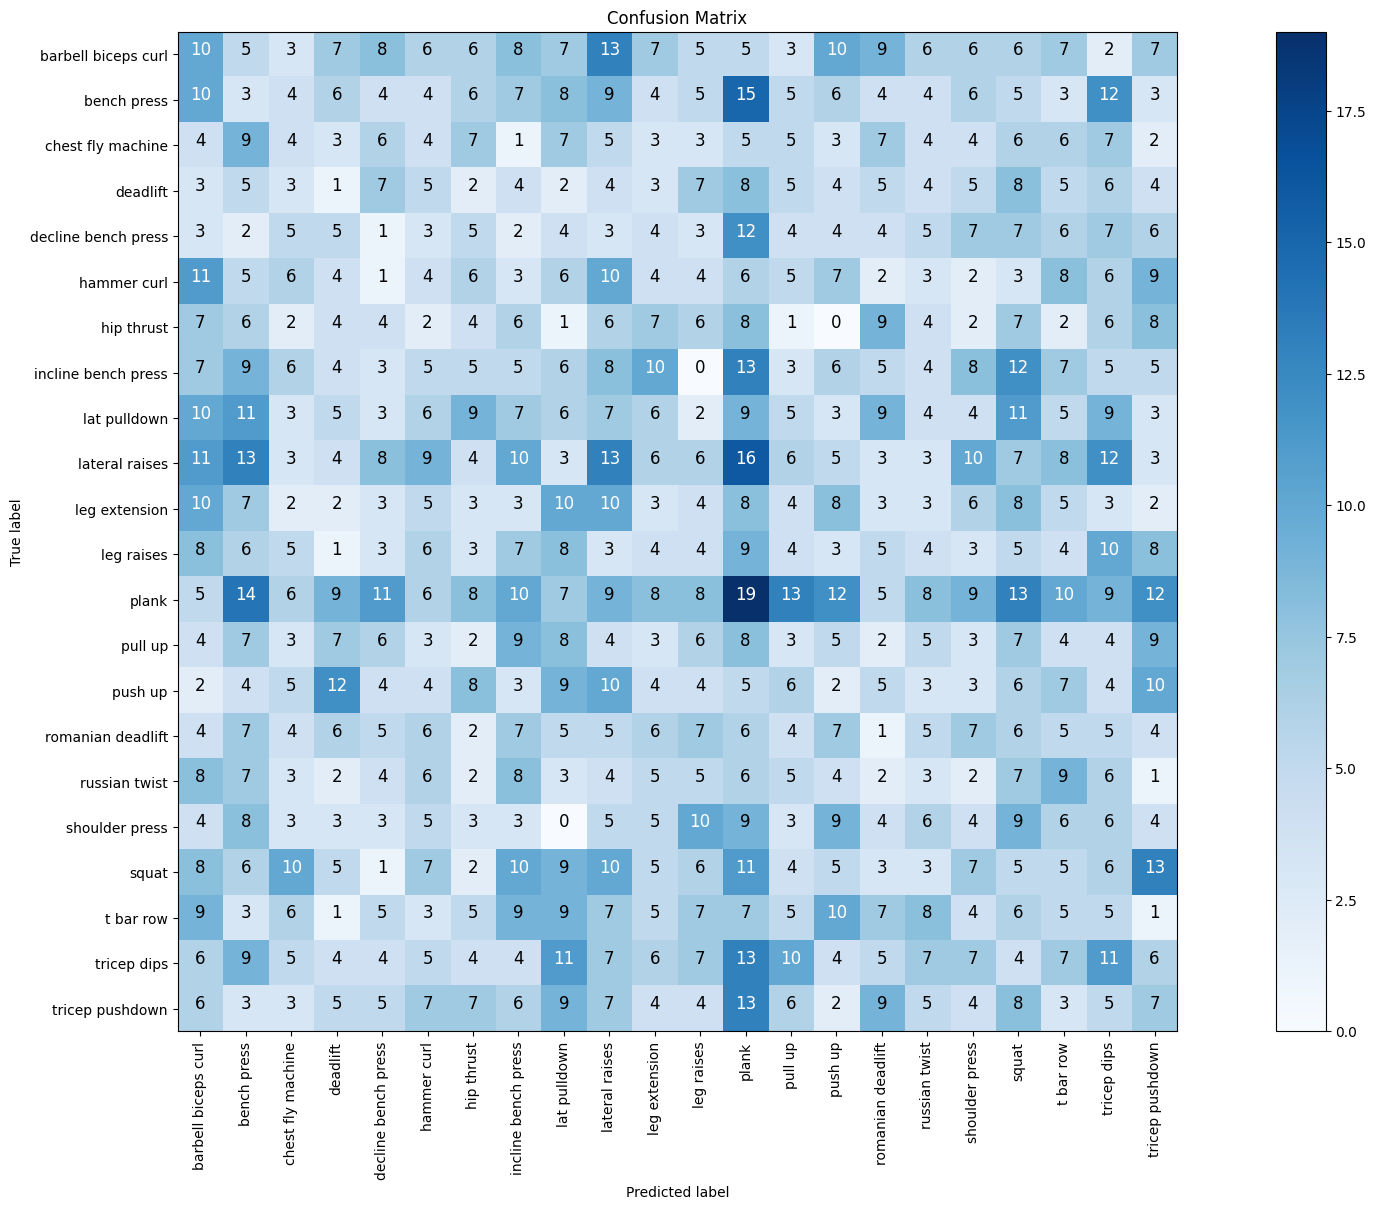

In [7]:
#get confusion matrix
cm = confusion_matrix(y_labels, y_preds)
# print(cm)

#plot
plot_confusion_matrix(cm, labels, normalize=False)

In [8]:
print(f'F1 score \n')

#F1 score
print('Macro: ', f1_score(y_labels, y_preds, average='macro'))
print('Micro: ', f1_score(y_labels, y_preds, average='micro'))
print('Weighted: ', f1_score(y_labels, y_preds, average='weighted'))
print('\nNone: ', f1_score(y_labels, y_preds, average=None))

F1 score 

Macro:  0.03902890863416496
Micro:  0.04249189773136478
Weighted:  0.04250785456132331

None:  [0.06756757 0.0212766  0.04020101 0.01       0.00995025 0.03539823
 0.03902439 0.03731343 0.04363636 0.08074534 0.02678571 0.03539823
 0.09004739 0.02714932 0.0167364  0.00900901 0.02955665 0.03555556
 0.03367003 0.03937008 0.07534247 0.05490196]
